In [1]:
import pandas as pd
import numpy as np
import os
import csv
import re
import matplotlib.pyplot as plt

from typing import Type, Union, List, Dict

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline as skPipeline

# The Pipeline
1. Read formatted data as DF
2. Add salary tiers to DF
3. Retain desired subset of features and remove rest from DF
4. Split data into train/test
5. Determine transformations for data (numerical/categorical)
6. Map numerical/categorical transformations to appropriate features using ColumnTransformer
7. Add transformations to a sklearn Pipeline
8. Add a predictive model to the same Pipeline
9. Fit model on training data
10. Cross-validate
11. Score on test data

In [2]:
debug = True
src_dir = os.getcwd()
data_dir = os.path.join(src_dir, "Data")

In [3]:
merged_data_file = os.path.join(data_dir, "nba_stats_sal_merged_1990_2017.csv")
merged_data = pd.read_csv(merged_data_file)

In [4]:
if debug: 
    print("Input Data:")
    print(merged_data.iloc[list(range(5)) + list(range(-5, 0)), 
                   list(range(5)) + list(range(-5, 0))])

Input Data:
       Season End             Player Pos  Age   Tm  BLK  TOV   PF   PTS  \
0            1990         Mark Acres   C   27  ORL   25   70  248   362   
1            1990      Michael Adams  PG   27  DEN    3  141  133  1221   
2            1990       Mark Aguirre  SF   30  DET   19  121  201  1099   
3            1990        Danny Ainge  PG   30  SAC   18  185  238  1342   
4            1990        Mark Alarie  PF   26  WSB   39  101  219   860   
10580        2017        Cody Zeller  PF   24  CHO   58   65  189   639   
10581        2017       Tyler Zeller   C   27  BOS   21   20   61   178   
10582        2017  Stephen Zimmerman   C   20  ORL    5    3   17    23   
10583        2017        Paul Zipser  SF   22  CHI   16   40   78   240   
10584        2017        Ivica Zubac   C   19  LAL   33   30   66   284   

         Salary  
0        437000  
1        825000  
2       1115000  
3        725000  
4        500000  
10580  12584270  
10581   1709538  
10582   1312611  


## Preprocessing Steps
- Already took care of null data (when reading from original CSVs and merging)
- Try different normalization, standardization techniques and see effect on performance
- The only categorical variable to be encoded is Position; not using Team unfortunately b/c a) teams have changed and b) some players played for multiple teams, and thus have TOT as their team. Note that this variable is not ordinal, it's nominal. Also, beware multicollinearity.
- Split data by year, do scaling on separate DataFrames, then concatenate.
- Write different scaled data to different CSVs.

## Generating Salary Tiers

In [5]:
num_tiers = 10

In [6]:
def add_salary_tiers(num_tiers: int, merged_data: pd.DataFrame):
    # Compute max salaries per year
    salary_maxes = merged_data.groupby('Season End')['Salary'].max().to_dict()
    # Append salary tiers per player in a new column
    player_tiers = []
    for index, row in merged_data[['Season End', 'Salary']].iterrows():
        # +1 so we have num_tiers tiers (so the max falls in the highest tier)
        player_tiers.append(int(row['Salary'] / (salary_maxes[row['Season End']]+1) * num_tiers))
    if not 'Salary Tier' in merged_data.columns: 
        merged_data.insert(len(merged_data.columns), 'Salary Tier', pd.Series(player_tiers))
    else:
        merged_data['Salary Tier'] = pd.Series(player_tiers)

In [7]:
add_salary_tiers(num_tiers, merged_data)
if debug: 
    print("Merged With Salary Tier:")
    print(merged_data.iloc[list(range(5)) + list(range(-5, 0)), 
                   list(range(5)) + list(range(-5, 0))])

Merged With Salary Tier:
       Season End             Player Pos  Age   Tm  TOV   PF   PTS    Salary  \
0            1990         Mark Acres   C   27  ORL   70  248   362    437000   
1            1990      Michael Adams  PG   27  DEN  141  133  1221    825000   
2            1990       Mark Aguirre  SF   30  DET  121  201  1099   1115000   
3            1990        Danny Ainge  PG   30  SAC  185  238  1342    725000   
4            1990        Mark Alarie  PF   26  WSB  101  219   860    500000   
10580        2017        Cody Zeller  PF   24  CHO   65  189   639  12584270   
10581        2017       Tyler Zeller   C   27  BOS   20   61   178   1709538   
10582        2017  Stephen Zimmerman   C   20  ORL    3   17    23   1312611   
10583        2017        Paul Zipser  SF   22  CHI   40   78   240   1312611   
10584        2017        Ivica Zubac   C   19  LAL   30   66   284   1312611   

       Salary Tier  
0                1  
1                1  
2                2  
3         

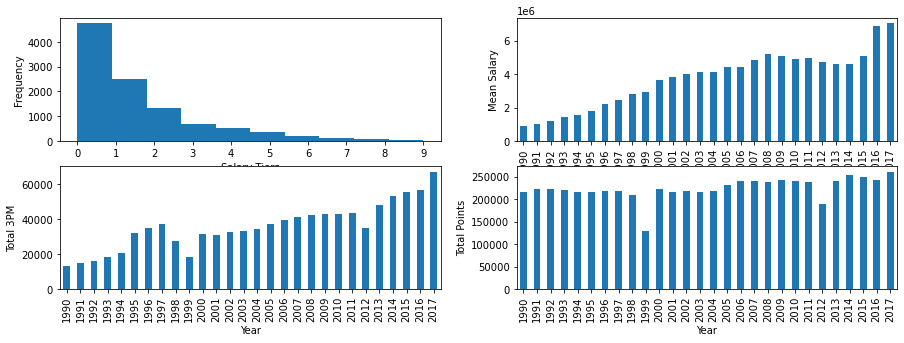

In [8]:
def plot_salary_info(merged_sal_tier: pd.DataFrame):
    fig, axs = plt.subplots(2, 2)
    fig.set_size_inches(15, 5)
    merged_data['Salary Tier'].plot.hist(ax=axs[0, 0], bins=num_tiers, xticks=list(range(num_tiers)))
    axs[0, 0].set_xlabel("Salary Tiers")
    merged_data.groupby('Season End')['Salary'].mean().sort_index().plot.bar(ax=axs[0, 1])
    axs[0, 1].set_xlabel("Year")
    axs[0, 1].set_ylabel("Mean Salary")
    merged_data.groupby('Season End')['3PA'].sum().sort_index().plot.bar(ax=axs[1, 0])
    axs[1, 0].set_xlabel("Year")
    axs[1, 0].set_ylabel("Total 3PM")
    merged_data.groupby('Season End')['PTS'].sum().sort_index().plot.bar(ax=axs[1, 1])
    axs[1, 1].set_xlabel("Year")
    axs[1, 1].set_ylabel("Total Points")
    plt.show()

if debug: plot_salary_info(merged_data)

In [9]:
# Export data

# Scikit-learn Pipeline

## 80/20 Train-Test Split

In [10]:
if debug: print("Merged w_sal columns:\n", merged_data.columns)

Merged w_sal columns:
 Index(['Season End', 'Player', 'Pos', 'Age', 'Tm', 'G', 'GS', 'MP', 'PER',
       'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%',
       'TOV%', 'USG%', 'OWS', 'DWS', 'WS', 'WS/48', 'OBPM', 'DBPM', 'BPM',
       'VORP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%',
       'eFG%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK',
       'TOV', 'PF', 'PTS', 'Salary', 'Salary Tier'],
      dtype='object')


In [11]:
def construct_final_df(merged_w_sal: pd.DataFrame, to_omit: List[str]):
    # Check that to_omit contains valid features
    if all(feature in merged_w_sal.columns for feature in to_omit):
        return merged_w_sal[[feature for feature in merged_w_sal.columns if not feature in to_omit]]
    else:
        raise ValueError("to_omit must contain valid features")

In [12]:
merged_data_final = construct_final_df(merged_data, ['Player', 'Tm', 'Salary'])
# TODO: Call something to make merged_data_final put categorical stuff first (or last)!!!
"""
merged_data_final = construct_final_df(merged_data_final, 
                                       [
                                        'Pos',
                                        'Age', 
                                        'G', 
                                        #'GS', 
                                        'MP',
                                        #'PER',
                                        #'TS%',
                                        #'3PAr', 
                                        #'FTr', 
                                        #'ORB%', 
                                        #'DRB%',
                                        'TRB%',
                                        #'AST%',
                                        #'STL%',
                                        #'BLK%',
                                        'TOV%',
                                        #'USG%',
                                        #'OWS',
                                        #'DWS',
                                        'WS',
                                        'WS/48',
                                        'OBPM', 
                                        'DBPM',
                                        #'BMP',
                                        #'VORP', 
                                        #'FG', 
                                        #'FGA',
                                        'FG%',
                                        #'3P', 
                                        #'3PA', 
                                        '3P%', 
                                        #'2P', 
                                        #'2PA', 
                                        '2P%',
                                        #'eFG%',
                                        #'FT',
                                        #'FTA', 
                                        'FT%',
                                        #'ORB', 
                                        #'DRB',
                                        'TRB',
                                        #'AST',
                                        #'STL',
                                        #'BLK',
                                        'TOV',
                                        #'PTS',
                                        'PF'
                                       ])
"""

"\nmerged_data_final = construct_final_df(merged_data_final, \n                                       [\n                                        'Pos',\n                                        'Age', \n                                        'G', \n                                        #'GS', \n                                        'MP',\n                                        #'PER',\n                                        #'TS%',\n                                        #'3PAr', \n                                        #'FTr', \n                                        #'ORB%', \n                                        #'DRB%',\n                                        'TRB%',\n                                        #'AST%',\n                                        #'STL%',\n                                        #'BLK%',\n                                        'TOV%',\n                                        #'USG%',\n                                        #'OWS',\n        

In [13]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbPipeline

In [14]:
y = merged_data_final.pop('Salary Tier')
X_train, X_test, y_train, y_test = train_test_split(merged_data_final, y, test_size=0.2)
if debug: 
    print("X_train shape: {} | y_train shape: {}".format(X_train.shape, y_train.shape))
    print("X_test shape: {} | y_test shape: {}".format(X_test.shape, y_test.shape))

X_train shape: (8468, 48) | y_train shape: (8468,)
X_test shape: (2117, 48) | y_test shape: (2117,)


## DO SOME FEATURE SELECTION HERE

## One Hot Encoding of Pos and Multicollinearity
We see that we don't need to worry about multicollinearity from these values.

In [15]:
if debug: 
    if 'Pos' in X_train.columns:
        print(X_train['Pos'].value_counts())

PF       1777
C        1731
PG       1655
SG       1617
SF       1569
SG-SF      22
SF-SG      19
C-PF       15
PF-C       15
SG-PG      13
SF-PF      11
PG-SG      11
PF-SF       9
SG-PF       3
PG-SF       1
Name: Pos, dtype: int64


In [16]:
# For reference, note that Transformers don't like 1D numpy arrays
#ohe = OneHotEncoder(sparse=False)
#print(ohe.fit_transform(X_train['Pos'].values.reshape(-1, 1)).shape)

### Categorical Transformation Pipeline
We will use a ColumnTransformer to fit transformations in parallel rather than run `cat_pipe.fit_transform(cat_Xtrain)` and `num_pipe.fit_transform(num_Xtrain)` ourselves sequentially.

In [17]:
# TransformerMixin: Need to implem fit and transform, we get fit_transform which invokes both
# BaseEstimator: We get get_params and set_params
class YearlyScaler(BaseEstimator, TransformerMixin):
    """
    Performs a Scaler Transform on the input DataFrame by year (groupby split-apply-combine strategy).
    
    Parameters
    ----------
    year_col : The name of the column containing years (to use for splitting)
    scaler : Some kind of Transformer
    return_df : Return a pd.Dataframe if True
    """
    def __init__(self, year_col: str, scaler: Type[Union[BaseEstimator, TransformerMixin]], 
                 return_df: bool = False):
        # TODO: FOR SOME REASON THESE CAN'T BE MANGLED...
        self.scaler = scaler
        self.year_col = year_col
        self.return_df = return_df
    
    def fit(self, X: pd.DataFrame, y=None):
        """
        Parameters
        ----------
        X : DataFrame, shape [n_samples, n_features]
            The data to fit.
        y : Ignored
        
        Returns
        -------
        self: object
            Fitted scaler
        """
        # TODO: ...BUT THESE CAN...
        # Omit the groupby column
        self._columns = [col for col in X.columns.values if col != self.year_col]
        
        return self
    
    def transform(self, X: pd.DataFrame) -> Union[pd.DataFrame, np.ndarray]:
        """
        Parameters
        ----------
        X : DataFrame, shape [n_samples, n_features]
            The data used to scale along the features axis.
            
        Returns
        -------
        X_tr : array-like, shape [n_samples, n_features]
            Transformed array.
        """
        # Apply the self._scaler transform on all the numerical columns grouped by the Year column
        # Remove the scaled Year column (iloc[:, 1:] says all rows, ignore 0th column, which is Year)
        # Will give us a multi-indexed DF with the years as the 0-level index
        X_tr = X[[self.year_col]+self._columns].groupby(self.year_col).apply(
            lambda x, scaler=self.scaler: pd.DataFrame(scaler.fit_transform(x)).iloc[:, 1:])
        # Drop the year index
        X_tr.index = X_tr.index.droplevel(0)
        
        return X_tr if self.return_df else X_tr.to_numpy()

    def get_feature_names(self) -> np.ndarray:
        return np.array(self._columns)

In [18]:
def construct_transformer(X_train: pd.DataFrame, 
                          scaler: Type[Union[BaseEstimator, TransformerMixin]],
                          year_col: str, n_jobs: int = None) -> ColumnTransformer:
    """
    n_jobs: -1 means use all processors. None means use 1.
    """
    # Get column types
    kinds = np.array([dt.kind for dt in X_train.dtypes])
    all_columns = X_train.columns.values
    is_num = kinds != 'O'
    num_cols = all_columns[is_num]
    cat_cols = all_columns[~is_num]

    # Define labeled categorical transformation steps
    # Dense matrix for potential time/space complexity
    # When encountering unknown labels (for test transform), ignore them
    cat_ohe_step = ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore')) 

    # Put the categorical transformations in a Pipeline to be executed sequentially
    cat_steps = [cat_ohe_step]
    cat_pipe = skPipeline(steps=cat_steps)

    # Define labeled numerical transformation steps
    num_scale_step = ('scale', YearlyScaler(year_col, scaler()))

    # Would do the following if creating a Pipeline to feed to ColumnTransformer
    # Put the numerical transformations in a Pipeline also
    num_steps = [num_scale_step]
    num_pipe = skPipeline(steps=num_steps)

    cat_col_transformers = ('cat', cat_pipe, cat_cols)
    num_col_transformers = ('num', num_pipe, num_cols)

    by_col_transformers = [cat_col_transformers, num_col_transformers]

    # Create ColumnTransformer which will apply transformations in parallel where possible
    col_transformer = ColumnTransformer(transformers=by_col_transformers, n_jobs=n_jobs)
    # We pass the whole training DataFrame because the transformers know which Pipelines
    # to apply to which columns (specified in the 'transformers' list)
    
    return col_transformer

In [19]:
class PipelineRFE(imbPipeline):

    def fit(self, X, y=None, **fit_params):
        super(PipelineRFE, self).fit(X, y, **fit_params)
        self.feature_importances_ = self.steps[-1][-1].feature_importances_
        return self

## Make the following a new notebook

In [20]:
# Try different scalers and run this cell
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import cross_val_score

from sklearn.metrics import roc_auc_score, precision_recall_fscore_support

import pickle

In [21]:
n_jobs = -1 # All processors
model_dir = os.path.join(src_dir, "Models")
os.makedirs(model_dir, exist_ok=True)  # Make directory if it doesn't exist

The following could be done in a loop but would require writing out all the arguments and storing in a dict or something, not worth it for just 3 classifiers

In [27]:
scalers = {"Normalize": MinMaxScaler, "Standardize": StandardScaler}
estimators = {
              'rfc': [RandomForestClassifier(n_jobs=n_jobs)], 
              'lgreg': [LogisticRegression(max_iter=4000, n_jobs=n_jobs)], 
              'mlp': [MLPClassifier(hidden_layer_sizes=(100, 100, 100), activation='relu', max_iter=400),
                     MLPClassifier(hidden_layer_sizes=(100, 100, 100), activation='tanh', max_iter=400)]
             }

def runEstimatorPipelineAndDisplayMetrics(X_train, y_train, X_test, y_test,
                                          scalers: Dict[str, List[Union[BaseEstimator, TransformerMixin]]],
                                          estimators,
                                          model_dir: str,
                                          over_sampling=False):
    """
    Blah
    """
    for scaler_name, scaler in scalers.items():
        col_transformer = construct_transformer(X_train, scaler, 'Season End', n_jobs)
        if debug:
            X_train_transformed = col_transformer.fit_transform(X_train)
            print("Transformed shape:", X_train_transformed.shape)
        for key, vals in estimators.items():
            filename = '{}_{}_SMOTE.sav'.format(key, scaler_name) if over_sampling \
                        else '{}_{}.sav'.format(key, scaler_name)
            if os.path.isfile(os.path.join(model_dir, filename)): continue
            idx = 1 if scaler == StandardScaler and key == 'mlp' else 0
            print("Estimator", key)
            if over_sampling:
                # SMOTE step will be skipped when scoring and predicting
                ml_pipe = imbPipeline(steps=[('transform', col_transformer), 
                                  ('smote', SMOTE('not majority')),
                                  ('est', vals[idx])])
            else:
                ml_pipe = skPipeline(steps=[('transform', col_transformer), 
                                  ('est', vals[idx])])
            ml_pipe.fit(X_train, y_train)
            
            pickle.dump(ml_pipe, open(os.path.join(model_dir, filename), 'wb'))
            
            scores = cross_val_score(ml_pipe, X_train, y_train, cv=5)
            print("5-Fold CV Scores:")
            print(scores)
            
            transform_steps = ml_pipe.named_steps['transform']
            feats = list(transform_steps.named_transformers_['num'].named_steps['scale'].get_feature_names())
            if 'cat' in transform_steps.named_transformers_:
                feats += list(transform_steps.named_transformers_['cat'].named_steps['ohe'].get_feature_names())
            if key == 'rfc':
                importances = ml_pipe.named_steps['est'].feature_importances_
                print("Sorted Features and Importances:")
                for feature in sorted(zip(importances, feats), reverse=True):
                    print(feature)
                
            print("Score on Test Set:", ml_pipe.score(X_test, y_test))
            print("ROC_AUC:", roc_auc_score(y_test, ml_pipe.predict_proba(X_test), 
                                            average='weighted', multi_class='ovo'))
            print("Precision, recall, f_score, support:")
            print(precision_recall_fscore_support(y_test, ml_pipe.predict(X_test)))
            print('\n')
        

In [25]:
runEstimatorPipelineAndDisplayMetrics(X_train, y_train, X_test, y_test, scalers, estimators, model_dir, True)

Transformed shape: (8468, 61)
Transformed shape: (8468, 61)
Estimator rfc
5-Fold CV Scores:
[0.34946871 0.33884298 0.34297521 0.35676314 0.35144714]
Sorted Features and Importances:
(0.025363604435171324, 'USG%')
(0.02361403683909345, 'x0_PG')
(0.023292500943333384, '3P')
(0.023191018627532936, 'PF')
(0.02268324680368436, '3P%')
(0.022251983826153808, 'BPM')
(0.02209157983038484, 'DBPM')
(0.022075482677412578, 'VORP')
(0.022029439696128784, 'x0_SF-SG')
(0.022017468895041078, 'FT%')
(0.02184799402871684, 'x0_SG')
(0.021780022336684843, 'FG')
(0.021777475623987737, 'WS/48')
(0.021777309281956328, 'FG%')
(0.021661237591565706, 'FGA')
(0.02158528169052897, 'FTA')
(0.021450177580721524, '2P')
(0.02138562759902591, '3PA')
(0.021277781170810296, 'DWS')
(0.021207768915166035, 'DRB')
(0.021013114376954637, '2P%')
(0.020924417885811723, 'OBPM')
(0.02086815473797895, 'x0_PF')
(0.020509335332366478, 'x0_C-PF')
(0.020459867242162172, 'BLK')
(0.02043810401684176, 'ORB')
(0.020162454640433983, '2PA')

In [28]:
runEstimatorPipelineAndDisplayMetrics(X_train, y_train, X_test, y_test, scalers, estimators, model_dir, False)

Transformed shape: (8468, 61)
Estimator rfc
5-Fold CV Scores:
[0.42561983 0.43270366 0.43211334 0.41169522 0.44300059]
Sorted Features and Importances:
(0.02421867278001105, '3P%')
(0.024166765972490786, 'x0_PG')
(0.02415639491739142, '2P')
(0.023817364161224742, 'FT%')
(0.023668240011139333, 'BPM')
(0.02344867585765958, 'FG')
(0.02327803258663534, '3P')
(0.023190641839025194, 'USG%')
(0.022959235518875524, 'x0_C-PF')
(0.022820761969876303, 'STL')
(0.02281952525132581, 'OBPM')
(0.022818184414334582, 'FT')
(0.022795400545448645, 'VORP')
(0.022792386109078442, 'FG%')
(0.02261265812058329, '2PA')
(0.02229108655286044, 'DRB')
(0.022103677540803904, 'x0_PF')
(0.02198922001326862, '3PA')
(0.021892694707364442, 'WS/48')
(0.02183170977397415, 'FGA')
(0.021723480856708912, 'x0_SG-PG')
(0.02154753471005039, 'FTA')
(0.021533622619444536, 'x0_SF-SG')
(0.021492733155273874, 'ORB')
(0.021179735460239404, 'x0_SF-PF')
(0.020982041996079035, 'OWS')
(0.02097967156761679, 'x0_SG-PF')
(0.02095521071386141

/home/davidqin/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(array([0.45154744, 0.26428571, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ]), array([0.93193717, 0.0707457 , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ]), array([0.60833903, 0.11161388, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ]), array([955, 523, 236, 149,  98,  69,  40,  17,  20,  10]))


Estimator lgreg
5-Fold CV Scores:
[0.44746163 0.44746163 0.44273908 0.44595393 0.44240992]
Score on Test Set: 0.44922059518186114
ROC_AUC: 0.5193782527991648
Precision, recall, f_score, support:
(array([0.45232391, 0.23333333, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ]), array([0.98848168, 0.01338432, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ]), array([0.62064431, 0.02531646, 0.        , 0.        , 0.     

/home/davidqin/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/davidqin/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/davidqin/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/davidqin/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: 

5-Fold CV Scores:
[0.27449823 0.27154664 0.28807556 0.29119905 0.28824572]
Score on Test Set: 0.26263580538497877
ROC_AUC: 0.4855261155904221
Precision, recall, f_score, support:
(array([0.41802389, 0.24524313, 0.13584906, 0.06989247, 0.03053435,
       0.02739726, 0.        , 0.        , 0.        , 0.        ]), array([0.40314136, 0.22179732, 0.15254237, 0.08724832, 0.04081633,
       0.02898551, 0.        , 0.        , 0.        , 0.        ]), array([0.41044776, 0.23293173, 0.14371257, 0.07761194, 0.0349345 ,
       0.02816901, 0.        , 0.        , 0.        , 0.        ]), array([955, 523, 236, 149,  98,  69,  40,  17,  20,  10]))


Transformed shape: (8468, 61)
Estimator rfc
5-Fold CV Scores:
[0.42502952 0.43919717 0.42975207 0.43591258 0.43532191]
Sorted Features and Importances:
(0.025949412957354156, 'USG%')
(0.024516091866566003, 'BPM')
(0.023535061769445243, 'x0_PG')
(0.02348052857933246, 'DWS')
(0.02334840369093951, '3P%')
(0.023019442749946734, 'FG%')
(0.022805953266167

/home/davidqin/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


5-Fold CV Scores:
[0.44510035 0.44687131 0.44569067 0.44713526 0.44300059]
Score on Test Set: 0.44922059518186114
ROC_AUC: 0.5155593478311236
Precision, recall, f_score, support:
(array([0.45028409, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ]), array([0.99581152, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ]), array([0.62014998, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ]), array([955, 523, 236, 149,  98,  69,  40,  17,  20,  10]))


Estimator mlp


/home/davidqin/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


5-Fold CV Scores:
[0.29456907 0.2892562  0.28571429 0.28292971 0.30596574]
Score on Test Set: 0.298063297118564
ROC_AUC: 0.507755174750362
Precision, recall, f_score, support:
(array([0.44956772, 0.23230088, 0.13059701, 0.08403361, 0.08080808,
       0.05555556, 0.03030303, 0.        , 0.        , 0.        ]), array([0.49005236, 0.20076482, 0.14830508, 0.06711409, 0.08163265,
       0.05797101, 0.025     , 0.        , 0.        , 0.        ]), array([0.46893788, 0.21538462, 0.13888889, 0.07462687, 0.08121827,
       0.05673759, 0.02739726, 0.        , 0.        , 0.        ]), array([955, 523, 236, 149,  98,  69,  40,  17,  20,  10]))


